# Insurance drop-out
A key risk for firms that are highly exposed to climate risk is the refusal of insurancers to insure their assets. In this notebook, we show how to model an insurance drop-out for a specific asset and the impact on the physical climate risk.

In [12]:
from prisk.flood import FloodExposure, FloodEntitySim
from prisk.kernel import Kernel
from prisk.asset import PowerPlant
from prisk.insurance import Insurance
from prisk.kernel import InsuranceDropoutEvent
from prisk.utils import convert_to_continous_damage, plot_risk_factors

import pandas as pd
import numpy as np

In [2]:
power = pd.read_excel("../Data/power.xlsx")
power.drop_duplicates(subset=["Plant / Project name", "Type", "Capacity (MW)", "Country", "Owner"], inplace=True)
power.drop(columns=[2], inplace=True)
damage_curves = pd.read_excel("../Data/damage_curves.xlsx")
continuous_curves = convert_to_continous_damage(damage_curves)
return_period_columns = [c for c in power.columns if isinstance(c, int)]
firm = power.iloc[0]

## Simulations
The notebook will implement two simulations to illustrate the impact of insurance dropouts. In the first simulation, there is no dropout of insurers and the asset remains insured. In the second simulation, the insurer drops out after 5 years.

#### No dropout

Mean P-risk: 0.92
Standard deviation: 0.04
5th percentile: 0.84
95th percentile: 0.95


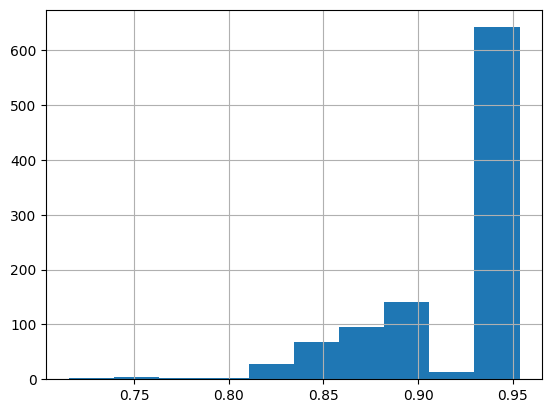

In [9]:
simulations = 1000
prisks = np.repeat(0.0, simulations)
insurer_capital = np.repeat(0.0, simulations)
capital_damages = np.repeat(0.0, simulations)
business_disruption = np.repeat(0.0, simulations)
fair_premiums = np.repeat(0.0, simulations)
insurance_adjustments = np.repeat(0.0, simulations)
npvs = np.repeat(0.0, simulations)

insurer = Insurance(name="Insurer", capital=1e9)
flood_exposure = [FloodExposure(return_period, firm[return_period]) 
                    for return_period in return_period_columns if firm[return_period] > 0
    ]
production_path = np.repeat(firm["Capacity (MW)"]*24*365, 25) # Assume constant production path
for i in range(simulations):
    asset = PowerPlant(
        name=firm["Plant / Project name"],
        flood_damage_curve=continuous_curves,
        flood_exposure=flood_exposure,
        production_path=production_path,
        replacement_cost=firm["Value"],
    )
    asset.add_insurer(insurer)
    kernel = Kernel(assets=[asset], insurers=[insurer])
    FloodEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
    kernel.run(time_horizon=25)
    prisk = max(asset.npv/asset.base_value, 0)
    prisks[i] = prisk
    insurer_capital[i] = insurer.capital
    capital_damages[i] = asset.total_replacement_costs
    business_disruption[i] = asset.total_business_disruption
    fair_premiums[i] = asset.total_fair_insurance_premiums
    insurance_adjustments[i] = asset.total_insurance_adjustments
    npvs[i] = asset.npv

print(f"Mean P-risk: {np.mean(prisks):.2f}")
print(f"Standard deviation: {np.std(prisks):.2f}")
print(f"5th percentile: {np.percentile(prisks, 5):.2f}")
print(f"95th percentile: {np.percentile(prisks, 95):.2f}")
pd.Series(prisks).hist();

In [16]:
plot_risk_factors(base_value=asset.base_value, capital_damages=capital_damages.mean(),
                  business_disruption=business_disruption.mean(), fair_premium=fair_premiums.mean(),
                  insurance_adjustment=insurance_adjustments.mean(), npv=npvs.mean())

### Simulation with insurance dropout

Mean P-risk: 0.91
Standard deviation: 0.11
5th percentile: 0.69
95th percentile: 0.98


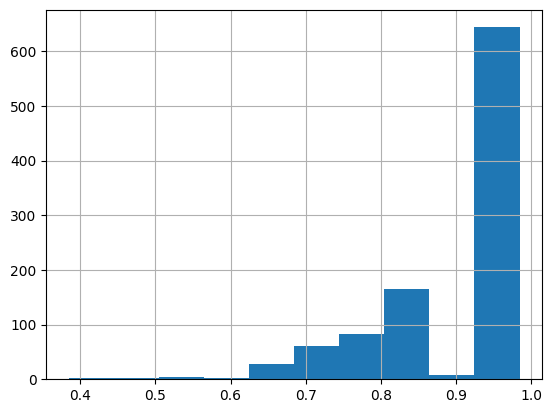

In [17]:
for i in range(simulations):
    asset = PowerPlant(
        name=firm["Plant / Project name"],
        flood_damage_curve=continuous_curves,
        flood_exposure=flood_exposure,
        production_path=production_path,
        replacement_cost=firm["Value"],
    )
    asset.add_insurer(insurer)
    kernel = Kernel(assets=[asset], insurers=[insurer])
    FloodEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
    InsuranceDropoutEvent(kernel.internal_time+5, asset).send(kernel)
    kernel.run(time_horizon=25)
    prisk = max(asset.npv/asset.base_value, 0)
    prisks[i] = prisk
    insurer_capital[i] = insurer.capital
    capital_damages[i] = asset.total_replacement_costs
    business_disruption[i] = asset.total_business_disruption
    fair_premiums[i] = asset.total_fair_insurance_premiums
    insurance_adjustments[i] = asset.total_insurance_adjustments
    npvs[i] = asset.npv

print(f"Mean P-risk: {np.mean(prisks):.2f}")
print(f"Standard deviation: {np.std(prisks):.2f}")
print(f"5th percentile: {np.percentile(prisks, 5):.2f}")
print(f"95th percentile: {np.percentile(prisks, 95):.2f}")
pd.Series(prisks).hist();

In [18]:
plot_risk_factors(base_value=asset.base_value, capital_damages=capital_damages.mean(),
                  business_disruption=business_disruption.mean(), fair_premium=fair_premiums.mean(),
                  insurance_adjustment=insurance_adjustments.mean(), npv=npvs.mean())